In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


#enable IPython to display matplolib graphs
%matplotlib inline

from sklearn import tree


In [2]:
from ML_classes.DTModel import DTModel


2022-03-23 17:41:37.840241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 17:41:37.840257: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

#max_value_energy = df["energy(kWh/hh)"].max()
#df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
#df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000181")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)

In [5]:
# Initiating the class
DT = DTModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 20,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
DT.DTModel()

DecisionTreeRegressor()

In [7]:
yhat = DT.predict()
yhat

[0.018479566317473245,
 0.027043269747405264,
 0.02824519075778421,
 0.022385817436851314,
 0.023737979133216666,
 0.02478966169636535,
 0.027944711624567544,
 0.02614182563148684,
 0.056941105812283774,
 0.0504807719861614,
 0.02614182563148684,
 0.060697111768163156,
 0.022836537256054383,
 0.028094952310553947,
 0.03170071981920307,
 0.02403846050518947,
 0.03801081967560746,
 0.026592547689446053,
 0.025090143068338157,
 0.028395431443770613,
 0.07481971386332369,
 0.03575721162456754,
 0.05318509537889211,
 0.039062497761243854,
 0.10757211624567543,
 0.09465143963840614,
 0.09314903725605439,
 0.045823317436851314,
 0.07226562444031097,
 0.05603966169636535,
 0.05844350819463553,
 0.08759014306833815,
 0.05198317436851316,
 0.05198317436851316,
 0.07527042920501446,
 0.03786057675086491,
 0.031099759314013597,
 0.04236778837543246,
 0.03125,
 0.026442307003459647,
 0.030498798808824123,
 0.031550481371972805,
 0.036808894187716226,
 0.08533653053978596,
 0.12845552906141885,
 0.0

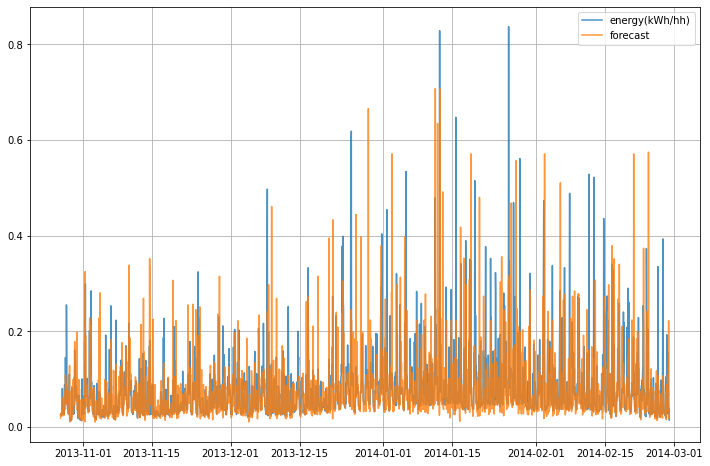

In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = DT.dc.create_X_Y(ts, lag=lag_model)
X = DT.alter_x_shape(X)
# Getting the forecast
yhat = DT.model.predict(X)

yhat = DT.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_350410/276845822.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


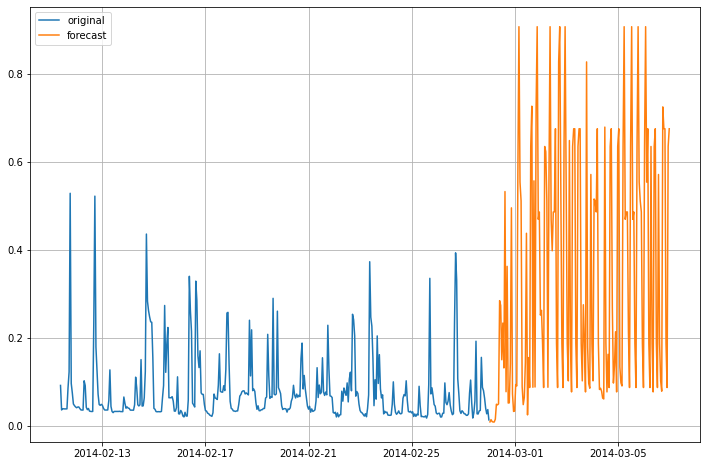

In [9]:
#Forecasting n steps ahead
n_ahead = 168
yhat = DT.predict_n_ahead(n_ahead)
yhat = [y[0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [10]:
DT.evaluateMSE()

0.006142093256874173

In [11]:
DT.evaluateRMSE()

0.07837150794054032

In [12]:
DT.evaluateMAE()

0.03766001913431637

In [13]:
DT.evaluateMAPE()

47.851667239582554

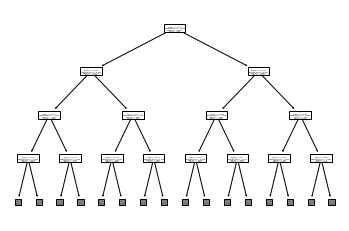

In [14]:
DT.plot_dt()

In [15]:
#train for all houses
lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in lclid_list:
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()

    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    
    # Initiating the class
    DT = DTModel(
    data = hh,
    Y_var = 'energy(kWh/hh)',
    lag = 24,
    epochs = 20,
    batch_size = 256,
    train_test_split = 0.15
    )
    #training
    DT.DTModel()
    
    mse.append(DT.evaluateMSE())
    rmse.append(DT.evaluateRMSE())
    mae.append(DT.evaluateMAE())
    mape.append(DT.evaluateMAPE())
houses = pd.Series(data=lclid_list,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape



In [16]:
res_df

,lclid,mse,rmse,mae,mape
0,MAC000168,0.010169,0.100844,0.038884,123.390627
1,MAC000169,0.012818,0.113218,0.065842,120.052409
2,MAC000179,0.009929,0.099643,0.054809,70.773327
3,MAC000181,0.006624,0.081390,0.037916,47.761323
4,MAC000165,0.013086,0.114393,0.070353,34.615316
5,MAC000173,0.015989,0.126447,0.077352,51.920302
6,MAC000152,0.014994,0.122448,0.068233,107.744949
7,MAC000153,0.011965,0.109384,0.073103,55.265819
8,MAC000159,0.008440,0.091870,0.055254,51.999335
9,MAC000150,0.013346,0.115525,0.066294,73.761763
